# Decision-making system, Temporal representation and Online Learning

In [1]:
# Import numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

import nengo

# Fix the numpy random seed for reproducible results
np.random.seed(18945)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

# 1. Building an Accumulate-to-Threshold Decision Making Model

One standard account for how brains make simple decision-making tasks is that they gradually accumulate evidence for or against something, and when that evidence hits some threshold, a decision is made.  This sort of model is used to account for the fact that people take longer to make decisions when the evidence is weak.

If you want more background on this, https://www.jneurosci.org/content/34/42/13870 gives a decent overview, but this diagram shows a high-level overview:

![](https://www.jneurosci.org/content/jneuro/34/42/13870/F1.large.jpg)

We're going to make a model of this process. It will make its choice based on a single input value, which gives some evidence as to which choice should be made.  It will indicate a choice by outputting either a 1 or a -1.  If that input evidence is positive, it will be more likely to make the first choice (outputting a 1), and if the input evidence is negative it will be more likely to make the second choice (outputting a -1).

*TIP: The Nengo GUI built-in tutorials 10 through 18 may be useful to give you an overview of different recurrent systems and different ways of modifying ```Ensembles```.*



**a) Accumulation. [2 marks]** Start by building a recurrent system that can add up evidence over time (the accumulator or integrator).  This is a neural ```Ensemble``` that holds a single dimension, and uses a small number of neurons (50).  Provide it with one input ```Node``` that has a constant value of ```[0.1]``` and connect that input into the ```Ensemble``` with a ```Connection```.  Now make a ```Connection``` from the ```Ensemble``` back to itself that computes the identity function.  Since this ```Connection``` is accumulating evidence over time, we want it to be fairly stable, so set ```synapse=0.1``` on this ```Connection``` (leave the other `Connection` at its default value).  This means that the neurotransmitter being used will spread out over 100ms, rather than the default 5ms.

If you run the above system with the constant positive input of 0.1 as noted above, the value stored in the accumulator should gradually increase until it hits 1 (this should take about 1 second of simulated time).  If you change the input to be -0.1, it should gradually decrease until it hits -1.

Make a single plot that shows the behaviour of the model for four different inputs: 0.2, 0.1, -0.1, and -0.2.  For each input, run the model for 2 seconds (`sim.run(2)`) and plot the value stored in the accumulator `Ensemble`.  Use a `Probe` synapse of 0.01 to get the stored value.

In [2]:
def recurrent_system(input_const):
    model = nengo.Network()
    with model:
        a = nengo.Ensemble(n_neurons=50, dimensions=1)

        stim = nengo.Node([input_const])
        nengo.Connection(stim, a)

        tau = 0.1
        nengo.Connection(a, a, synapse=tau)

        tau_probe = 0.01
        p_A = nengo.Probe(a, synapse=tau_probe)


    with nengo.Simulator(model) as sim:
        sim.run(2);
    
    return sim.trange(), sim.data[p_A]

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

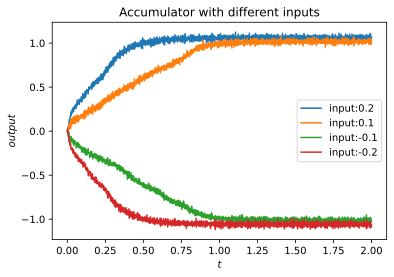

In [3]:
input_const = [0.2, 0.1, -0.1, -0.2]
plt.figure()
plt.title("Accumulator with different inputs")
plt.xlabel("$t$")
plt.ylabel("$output$")
for i in input_const: 
    t, sim_A = recurrent_system(i)
    plt.plot(t, sim_A, label="input:"+str(i))
plt.legend(); 

**b) Accumulator Discussion. [1 mark]** What is the mathematical computation being performed here (i.e. what is the relationship between the input and the output)?  Why does the value stop increasing (or decreasing) when it hits +1 (or -1)?

In this controlled integrator system, the input signal is accumulated and state can be directly manipulated by the control signal. The integrator dynamics can be described as: 

$$\frac{\mathrm{d}\vec x(t)}{\mathrm{d}t} = \mathbf{A} \mathbf{x} + \mathbf{B} \mathbf{u}$$

where $\mathbf{x}$ is the neuron behaviour, $\mathbf{u}$ is the input signal (a constant in this case). $\mathbf{B}$ represents the rate of integration/accumulation and is defined as $\tau$ synapse in above question.

The neuron group value stop increasing/decreasing after it hits +1/-1 because the neurons' maximum capacity is at magnitude = 1. This is because the default radius of the ensemble is set to be 1. 

**c) Adding random noise to the neurons. [1 mark]** Next, we can add randomness to the neurons.  In standard (non-neural) accumulator models, there is a "random-walk" component that randomly varies the value being accumulated.  We can model this by adding random noise into the ```Ensemble```, which means adding random current to each of the neurons.  The command for this is:

```python
acc.noise = nengo.processes.WhiteSignal(period=10, high=100, rms=1)
```

(where ```acc``` is whatever name you gave your accumulator ```Ensemble```.)

The strength of this noise is set by the ```rms=1``` parameter.  Generate the same plot as in part (a) but with the noise `rms=1`.  Also generate the same plot for `rms=3`, `rms=5`, and `rms=10`.  What happens to the resulting output?

In [4]:
def recurrent_system_with_noise(input_const, noise_rms):
    model = nengo.Network()
    with model:
        a = nengo.Ensemble(n_neurons=50, dimensions=1)
        a.noise = nengo.processes.WhiteSignal(period=10, high=100, rms=noise_rms)

        stim = nengo.Node([input_const])
        nengo.Connection(stim, a)

        tau = 0.1
        nengo.Connection(a, a, synapse=tau)

        tau_probe = 0.01
        p_A = nengo.Probe(a, synapse=tau_probe)


    with nengo.Simulator(model) as sim:
        sim.run(2);
    
    return sim.trange(), sim.data[p_A]

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

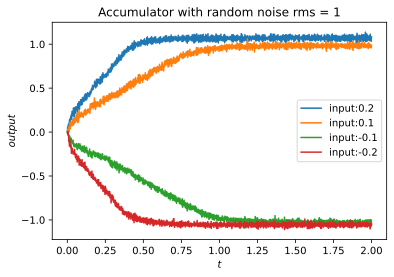

In [5]:
# noise rms = 1
input_const = [0.2, 0.1, -0.1, -0.2]
plt.figure()
plt.title("Accumulator with random noise rms = 1")
plt.xlabel("$t$")
plt.ylabel("$output$")
for i in input_const: 
    t, sim_A = recurrent_system_with_noise(i, 1);
    plt.plot(t, sim_A, label="input:"+str(i))
plt.legend(); 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

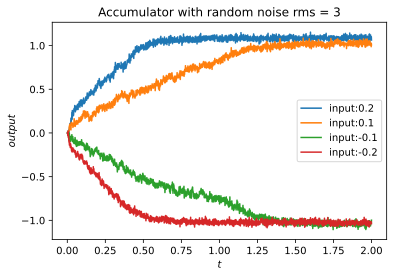

In [6]:
# noise rms = 3
input_const = [0.2, 0.1, -0.1, -0.2]
plt.figure()
plt.title("Accumulator with random noise rms = 3")
plt.xlabel("$t$")
plt.ylabel("$output$")
for i in input_const: 
    t, sim_A = recurrent_system_with_noise(i, 3);
    plt.plot(t, sim_A, label="input:"+str(i))
plt.legend(); 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

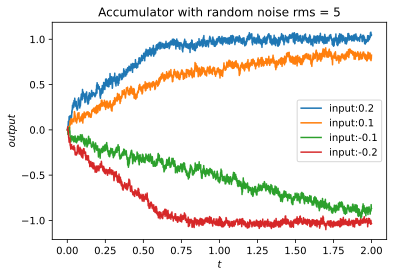

In [7]:
# noise rms = 5
input_const = [0.2, 0.1, -0.1, -0.2]
plt.figure()
plt.title("Accumulator with random noise rms = 5")
plt.xlabel("$t$")
plt.ylabel("$output$")
for i in input_const: 
    t, sim_A = recurrent_system_with_noise(i, 5);
    plt.plot(t, sim_A, label="input:"+str(i))
plt.legend(); 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

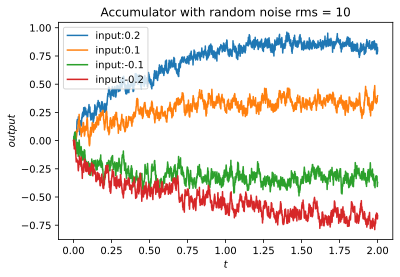

In [8]:
# noise rms = 10
input_const = [0.2, 0.1, -0.1, -0.2]
plt.figure()
plt.title("Accumulator with random noise rms = 10")
plt.xlabel("$t$")
plt.ylabel("$output$")
for i in input_const: 
    t, sim_A = recurrent_system_with_noise(i, 10);
    plt.plot(t, sim_A, label="input:"+str(i))
plt.legend(); 

As the strength of noise (rms) increases, the amount of oscillation in the produced signal increases and it gets harder to observe the exact time at which signals saturate at +/-1. As shown in the figure for outputs when noise rms = 10, it is also hard to observe whether the signal actually reached +/-1 or not due to the large amount of noise and oscillation present in the signal. 

**e) Adding decision-making. [2 marks]** To complete the basic model, we want to determine when this accumulator passes some threshold.  If the value becomes large enough, we should make one choice (+1), and if it becomes small enough we should make the other choice (-1).  To achieve this, make a new output ```Ensemble``` that is also one-dimensional and has 50 neurons.  Form a ```Connection``` from the accumulator to this new ```Ensemble``` that computes the following function:

```python
def choice(x):
    if x[0] > 0.9:
        return 1
    elif x[0] < -0.9:
        return -1
    else: 
        return 0
```

This new output should now stay at zero until the accumulator value gets large enough, and then quickly move to +1 or -1.

Build this model and plot the output of both the accumulator `Ensemble` and the decision-making `Ensemble`.  Use a noise `rms=3` and for both `Probe`s use a synapse of 0.01.  Do this for all four input values (0.2, 0.1, -0.1, and -0.2).

How well does the system perform?  Does it make decisions faster when there is stronger evidence?  What differences are there (if any) between the computation we are asking the system to perform and the actual result?

*TIP: try running the model a few times to see the variability in the output*

In [9]:
def decision_system(input_const): 
    model = nengo.Network()
    with model:
        accumulator = nengo.Ensemble(n_neurons=50, dimensions=1)
        accumulator.noise = nengo.processes.WhiteSignal(period=10, high=100, rms=3)
        decision_making = nengo.Ensemble(n_neurons=50, dimensions=1)

        stim = nengo.Node([input_const])
        nengo.Connection(stim, accumulator)

        tau = 0.1
        nengo.Connection(accumulator, accumulator, synapse=tau)

        def choice(x): 
            if x[0] > 0.9:
                return 1
            elif x[0] < -0.9:
                return -1
            else: 
                return 0

        nengo.Connection(accumulator, decision_making, function=choice)

        tau_probe = 0.01
        p_A = nengo.Probe(accumulator, synapse=tau_probe)
        p_D = nengo.Probe(decision_making, synapse=tau_probe)

    with nengo.Simulator(model) as sim:
        sim.run(2);
        
    return sim.trange(), sim.data[p_A], sim.data[p_D]

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

<Figure size 432x288 with 0 Axes>

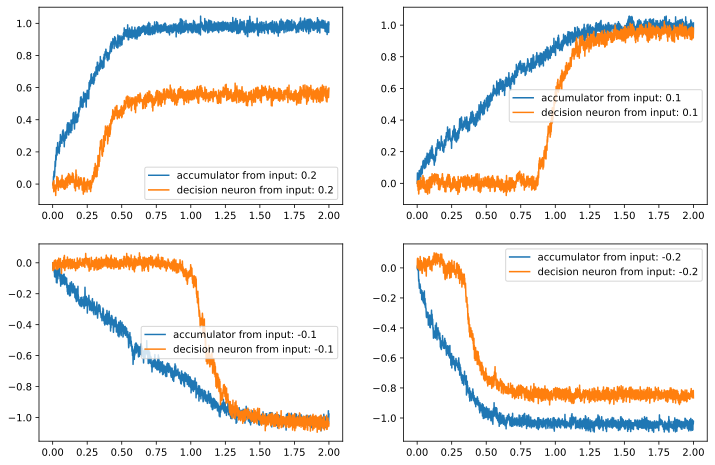

In [10]:
input_const = [0.2, 0.1, -0.1, -0.2]
plt.figure()
plt.subplots(figsize=(12, 8))
plt.xlabel("$t$")
plt.ylabel("$output$")

for i,x in enumerate(input_const): 
    t, sim_A, sim_D = decision_system(x)
    plt.subplot(2, 2, i+1)
    plt.plot(t, sim_A, label="accumulator from input: "+str(x))
    plt.plot(t, sim_D, label="decision neuron from input: "+str(x))
    plt.legend(loc='best'); 

The system performance generally follows what is expected from the description: decision-making is faster when the evidence is stronger (when input value is larger in magnitude). By running the system for a few times repeatedly, it is also observed that sometimes the decision neuron would not approach the value of +/-1 and stay at a number in the middle (-0.6 for when input is -0.1 is observed). This output result does not match the computation since in the computation, there should only be three kinds of output: 1, -1 or 0, and any transition should occur at a faster rate. 

**f) Combining Ensembles. [2 marks]** An alternative implementation would be to combine the two separate 1-dimensional `Ensembles` into one 2-dimensional `Ensemble`.  The Connections are made similarly as in the original model, but they need to target the particular dimensions involved using the ```ens[0]``` and ```ens[1]``` syntax.  Try building the model this way and plot the results.  Do this for a single `Ensemble` with 100 neurons (the same number as the total number of neurons in the original model) and with 500 neurons.  Also, be sure to increase the `radius` as would be appropriate in order to produce values like what we had in the original model, where the accumulator might be storing a 1 and the output might be a 1.

How does combining Ensembles in this way change the performance of the system?  

When the Ensembles are combined together in this way, what are we changing about the biological claims about the model?  In particular, how might we determine whether the real biologicial system has these as separate `Ensembles` or combined together?

In [11]:
def decision_system_combined(input_const, n_neu): 
    model = nengo.Network()
    with model:
        comb_ens = nengo.Ensemble(n_neurons=n_neu, dimensions=2, radius=2)
        comb_ens[0].noise = nengo.processes.WhiteSignal(period=10, high=100, rms=3)

        stim = nengo.Node([input_const])
        nengo.Connection(stim, comb_ens[0])

        tau = 0.1
        nengo.Connection(comb_ens[0], comb_ens[0], synapse=tau)

        def choice(x): 
            if x[0] > 0.9:
                return 1
            elif x[0] < -0.9:
                return -1
            else: 
                return 0

        nengo.Connection(comb_ens[0], comb_ens[1], function=choice)

        tau_probe = 0.01
        p_A = nengo.Probe(comb_ens[0], synapse=tau_probe)
        p_D = nengo.Probe(comb_ens[1], synapse=tau_probe)

    with nengo.Simulator(model) as sim:
        sim.run(2);
             
    return sim.trange(), sim.data[p_A], sim.data[p_D]   

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

<Figure size 432x288 with 0 Axes>

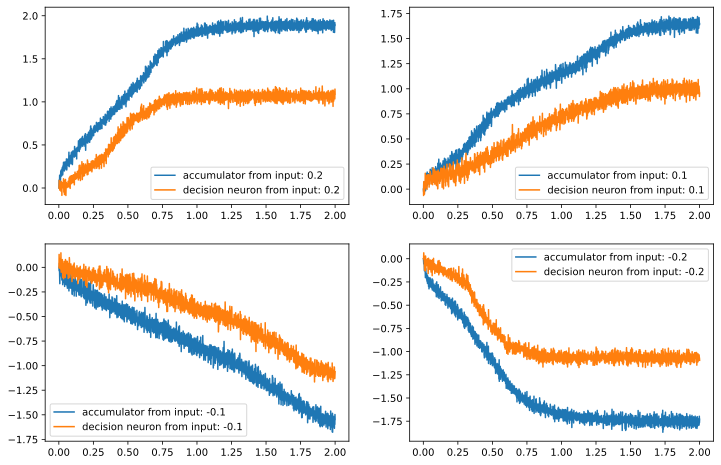

In [12]:
input_const = [0.2, 0.1, -0.1, -0.2]
plt.figure()
plt.subplots(figsize=(12, 8))
plt.xlabel("$t$")
plt.ylabel("$output$")

# neuron number = 100
for i,x in enumerate(input_const): 
    t, sim_A, sim_D = decision_system_combined(x, 100)
    plt.subplot(2, 2, i+1)
    plt.plot(t, sim_A, label="accumulator from input: "+str(x))
    plt.plot(t, sim_D, label="decision neuron from input: "+str(x))
    plt.legend(loc='best'); 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

<Figure size 432x288 with 0 Axes>

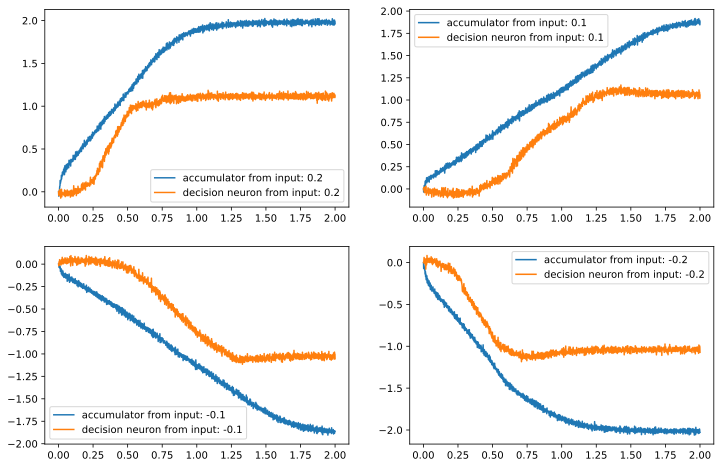

In [13]:
plt.figure()
plt.subplots(figsize=(12, 8))
plt.title("Accumulator with random noise rms = 1")
plt.xlabel("$t$")
plt.ylabel("$output$")

# neuron number = 500
for i,x in enumerate(input_const): 
    t, sim_A, sim_D = decision_system_combined(x, 500)
    plt.subplot(2, 2, i+1)
    plt.plot(t, sim_A, label="accumulator from input: "+str(x))
    plt.plot(t, sim_D, label="decision neuron from input: "+str(x))
    plt.legend(loc='best'); 

Combining the ensembles make the decision-maker output approaches 1 in a slower rate, since the slope of the change in outputs becomes less steep than when the ensembles are separated. Performance is better than when ensembles are separated, since decision making neuron output has less variability in repeated runs and will eventually stay in +/-1, making a concrete decision. When the number of neurons increase, the performance is better since less noise is present. 

Combining the accumulator and decision-making ensembles into 1 means that in biological point of view, the action of accumulating/saving up evidence and outputting the decision occurs at the same place/in the same group of neurons, rather than separated groups of neurons. We might conduct experiment to determine the locations of neurons performing evidence accumulation vs. decision making, and if they differ a lot in biological system it may be separated ensembles and if locations overlap, both actions may be performed by combined ensemble. Moreover, the rate of decision making for when ensembles are separated or combined can also be compared experimental results from real biological systems. If decision making neuron firing gradually increases with evidence buildup, it may be evidence for combined ensemble. If decision making occurs in neuron in a fast, rapid manner as observed when ensembles are separated, it may be evidence for separate ensembles. 

**g) Improving Representation [2 marks].** Returning to the original implementation from section (e) (with 2 separate Ensembles), we can improve the performance by adjusting the tuning curves of the second `Ensemble`.  Do this by setting `intercepts = nengo.dists.Uniform(0.4, 0.9)`.  This randomly chooses the x-intercepts of the neurons uniformly between 0.4 and 0.9, rather than the default of -1 to 1.  Generate the same plot as in part (e).

How does this affect the performance of the model?  (Try running the model a few times to see the variability in performance). 

Why does the output stay at exactly zero up until the decision is made (rather than being randomly jittering around zero, as in the previous models)?  

Why couldn't we use this approach in the case from part (f) where the `Ensembles` are combined?

In [14]:
def decision_system_adjusted(input_const): 
    model = nengo.Network()
    with model:
        accumulator = nengo.Ensemble(n_neurons=50, dimensions=1)
        accumulator.noise = nengo.processes.WhiteSignal(period=10, high=100, rms=3)
        decision_making = nengo.Ensemble(n_neurons=50, dimensions=1, intercepts = nengo.dists.Uniform(0.4, 0.9))

        stim = nengo.Node([input_const])
        nengo.Connection(stim, accumulator)

        tau = 0.1
        nengo.Connection(accumulator, accumulator, synapse=tau)

        def choice(x): 
            if x[0] > 0.9:
                return 1
            elif x[0] < -0.9:
                return -1
            else: 
                return 0

        nengo.Connection(accumulator, decision_making, function=choice)

        tau_probe = 0.01
        p_A = nengo.Probe(accumulator, synapse=tau_probe)
        p_D = nengo.Probe(decision_making, synapse=tau_probe)

    with nengo.Simulator(model) as sim:
        sim.run(2);
        
    return sim.trange(), sim.data[p_A], sim.data[p_D]

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

<Figure size 432x288 with 0 Axes>

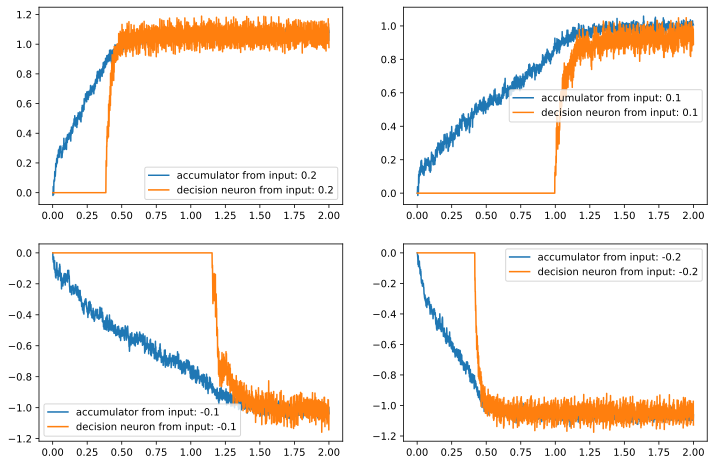

In [15]:
input_const = [0.2, 0.1, -0.1, -0.2]
plt.figure()
plt.subplots(figsize=(12, 8))
plt.title("Accumulator with random noise rms = 1")
plt.xlabel("$t$")
plt.ylabel("$output$")

for i,x in enumerate(input_const): 
    t, sim_A, sim_D = decision_system_adjusted(x)
    plt.subplot(2, 2, i+1)
    plt.plot(t, sim_A, label="accumulator from input: "+str(x))
    plt.plot(t, sim_D, label="decision neuron from input: "+str(x))
    plt.legend(loc='best'); 

There is still variability in the neuron outputs in this model, as observed after running the model repeatedly for a few times. There is definitely less errors and improved performance when decision needs to stay at 0, as there are less oscilation on the graph when decision is 0.  
The output stays at exactly zero with no noise present up until the decision is made is because the change in intercepts for the decision-making neurons. In the default ensemble settings, about half of the neurons are tuned for fire more for smaller values. But since the decision-making neurons should have output of 0 when input has magnitude less than 0.9, there is no need to have neurons tuned to inputs with small values. Hence, shifting the intercepts would result in less noise when accumulator values have small magnitude (<0.4) and have not reached threshold for decision-making. 

The approach cannot be used in part (f) where Ensembles are combined as 1 because intercepts change would be reflected on both accumulator and the decison-making neurons. Accumulator should not ignore evidence that is less than 0.4 and should keep at the default settings.  

# 2. Temporal Representation

In class, we discussed the Legendre Memory Unit (LMU), a method for storing input information over time.  This allows us to make connections where the function being computed is a function of the input over some window in time, rather having to be a function of the current input.

In this question, we will use this to build a model that can distinguish a 1Hz sine wave from a 2Hz sine wave.  Notice that it is impossible to perform this task without having information over time; if I just give you a single number at any given point in time, you can't tell whether it's from a 1Hz sine wave or a 2Hz sine wave.  So we need some method to store the previous input information, and that's what the LMU does.

**a) Representing Information over Time. [2 marks]** The core of the LMU is to compute the differential equation ${dx \over dt} = Ax + Bu$ where $A$ and $B$ are carefully chosen using the following math:

```python
A = np.zeros((q, q))
B = np.zeros((q, 1))
for i in range(q):
    B[i] = (-1.)**i * (2*i+1)
    for j in range(q):
        A[i,j] = (2*i+1)*(-1 if i<j else (-1.)**(i-j+1)) 
A = A / theta
B = B / theta        
```

Implement this in Nengo.  Use `theta=0.5` and `q=6`.  The model should consist of a single `Ensemble` that is `q`-dimensional. Use 1000 neurons in this `Ensemble`.  Use `synapse=0.1` on both the recurrent `Connection` and on the input `Connection`.

For the input, give a 1Hz sine wave for the first 2 seconds, and a 2Hz sine wave for the second 2 seconds.  This can be done with:

```python
stim = nengo.Node(lambda t: np.sin(2*np.pi*t) if t<2 else np.sin(2*np.pi*t*2))
```

Run the simulation for 4 seconds.  Plot `x` over the 4 seconds using a `Probe` with `synapse=0.01`.  `x` should be 6-dimensional, and there should be a noticable change between its value before `t=2` and after `t=2`.

In [16]:
# LMU parameters 
theta = 0.5 
q = 6
tau = 0.1

# compute A and B
A = np.zeros((q, q))
B = np.zeros((q, 1))
for i in range(q):
    B[i] = (-1.)**i * (2*i+1)
    for j in range(q):
        A[i,j] = (2*i+1)*(-1 if i<j else (-1.)**(i-j+1)) 
A = A / theta
B = B / theta 

def make_nef_lti(tau, A, B):
    Ap = tau * A + np.eye(A.shape[0])
    Bp = tau * B
    return Ap, Bp

Ap, Bp = make_nef_lti(tau, A, B)

with nengo.Network() as net:
    stim = nengo.Node(lambda t: np.sin(2*np.pi*t) if t<2 else np.sin(2*np.pi*t*2))
    
    lmu = nengo.Ensemble(1000, q)
    
    nengo.Connection(stim, lmu, transform=Bp, synapse=0.1)
    nengo.Connection(lmu, lmu, transform=Ap, synapse=0.1)
    
    tau_probe = 0.01
    p_D = nengo.Probe(lmu, synapse=tau_probe)
    
    with nengo.Simulator(net) as sim:
        sim.run(4);

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

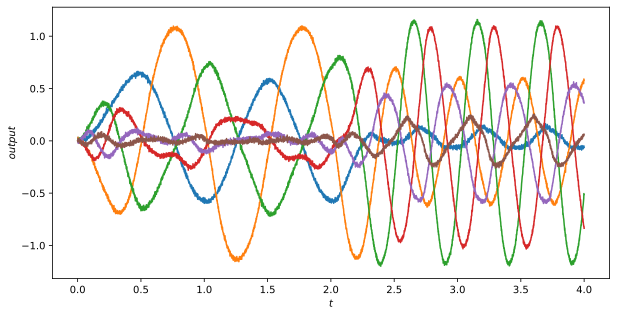

In [17]:
plt.figure(figsize=(10,5))
plt.xlabel("$t$")
plt.ylabel("$output$")
t = sim.trange()
plt.plot(t, sim.data[p_D])

In [18]:
x_values = sim.data[p_D]

**b) Computing the function. [2 marks]** We now want to compute our desired function, which is "output a 1 if we have a 1Hz sine wave and a 0 if we have a 2Hz sine wave".  To do this, we need to make a `Connection` from the LMU `Ensemble` out to a new `Ensemble` that will be our category.  Have it be 1-dimensional with 50 neurons.

Normally in Nengo, when we define a `Connection` we specify a Python function that we want to approximate.  Nengo will then choose a bunch of random `x` values, call the function to determine what the output should be for each one, and use that to solve for the decoders.  However, in this case, we already have that set of `x` values!  That's exactly the data you plotted in part (a).  For the `x` values from t=0 to t=2.0 we want an output of 1.  For the `x` values from t=2.0 to t=4.0, we want an output of -1.  So, to specify these target values, we make a matrix of size `(4000,1)` (4000 for the 4000 time steps that you have `x` values for, and 1 for the output being 1-dimensional).  Set the first 2000 values to 1 and the second 2000 values to -1.

Now that you have your `x` values and the corresponding `target` values, you can tell Nengo to use them when you make the `Connection` like this:

```python
nengo.Connection(a, b, eval_points=x_values, function=target)
```

That will tell Nengo just to use the values you're giving it, rather than randomly sampling `x` and calling a function to get the target values.

Build this model and plot the resulting category (with a `Probe` with `synapse=0.01`).  The output should be near 1 for the first 2 seconds, and near -1 for the second 2 seconds.  (Important note: it will not be perfect at this task!)

In [19]:
with nengo.Network() as net:
    stim = nengo.Node(lambda t: np.sin(2*np.pi*t) if t<2 else np.sin(2*np.pi*t*2))
    lmu = nengo.Ensemble(1000, q)
    output = nengo.Ensemble(50, 1)
    category = nengo.Ensemble(50, 1)
    
    nengo.Connection(stim, lmu, transform=Bp, synapse=0.1)
    nengo.Connection(lmu, lmu, transform=Ap, synapse=0.1)

    target = np.zeros((4000,1))
    target[:2000] = 1
    target[2000:] = -1
    
    nengo.Connection(lmu, category, eval_points=x_values, function=target)
        
    tau_probe = 0.01
    p_out = nengo.Probe(category, synapse=tau_probe)
    
    with nengo.Simulator(net) as sim:
        sim.run(4);

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

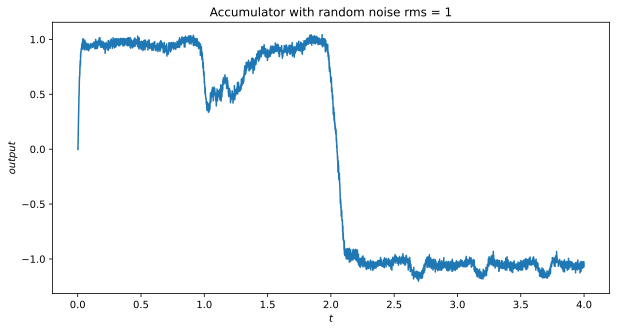

In [20]:
plt.figure(figsize=(10,5))
plt.title("Accumulator with random noise rms = 1")
plt.xlabel("$t$")
plt.ylabel("$output$")
t = sim.trange()
plt.plot(t, sim.data[p_out])

**c) Adjusting the input. [2 marks]** Repeat part b) but with an input that is a 2Hz sine wave for the first 2 seconds, and a 1Hz sine wave for the second 2 seconds (i.e. the opposite order as in part (b)).  How well does this perform?  Describe the similarities and differences.  One particular difference you should notice is that the model may make the wrong classification for the first 0.25 seconds.  Why is this happening?  What could you change to fix this?

In [21]:
with nengo.Network() as net:
    stim = nengo.Node(lambda t: np.sin(2*np.pi*t*2) if t<2 else np.sin(2*np.pi*t))
    lmu = nengo.Ensemble(1000, q)
    category = nengo.Ensemble(50, 1)
    
    nengo.Connection(stim, lmu, transform=Bp, synapse=0.1)
    nengo.Connection(lmu, lmu, transform=Ap, synapse=0.1)

    target = np.zeros((4000,1))
    target[:2000] = 1
    target[2000:] = -1
    
    nengo.Connection(lmu, category, eval_points=x_values, function=target)
    
    tau_probe = 0.01
    p_out = nengo.Probe(category, synapse=tau_probe)
    
with nengo.Simulator(net) as sim:
    sim.run(4);

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

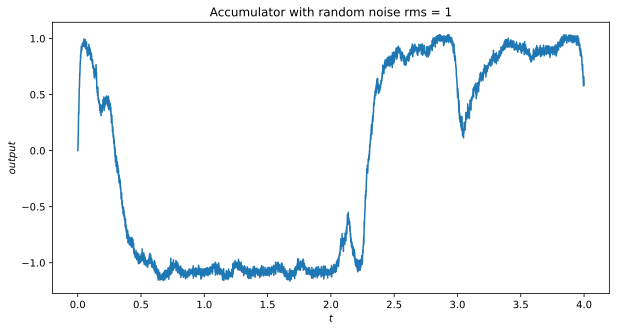

In [22]:
plt.figure(figsize=(10,5))
plt.title("Accumulator with random noise rms = 1")
plt.xlabel("$t$")
plt.ylabel("$output$")
t = sim.trange()
plt.plot(t, sim.data[p_out])

This performs relatively well as it distinguishes the change in signal and outputs -1 for the first 2 seconds and 1 for the second 2 seconds. The slight drop from 1 at around half of the 1Hz signal is the same across 2 graphs. The model differs in the first 0.25s where the classification done is incorrect, as it starts at 1 and then approach -1 afterwards. This may be because the sine waves for 1Hz and 2Hz are very similar at the first 0.25s. This may be compensated by adding delay network, increasing the order of polynomials or shifting the input to make the difference larger between 1Hz and 2Hz at the beginning.

**d) Adjusting the number of neurons. [2 marks]** Repeat part b) but adjust the number of neurons in the `Ensemble` computing the differential equation.  Try 50, 100, 200, 500, 1000, 2000, and 5000.  How does the model behaviour change?  Why does this happen?  In addition to looking at the actual results for each run, also plot the RMSE in the classification as you adjust the number of neurons.  

In [23]:
def lmu_classification(n_neurons, q): 
    # LMU parameters 
    theta = 0.5 
    
    # compute A and B
    A = np.zeros((q, q))
    B = np.zeros((q, 1))
    for i in range(q):
        B[i] = (-1.)**i * (2*i+1)
        for j in range(q):
            A[i,j] = (2*i+1)*(-1 if i<j else (-1.)**(i-j+1)) 
    A = A / theta
    B = B / theta 
    Ap, Bp = make_nef_lti(tau, A, B)
    
    with nengo.Network("x_values") as net:
        stim = nengo.Node(lambda t: np.sin(2*np.pi*t) if t<2 else np.sin(2*np.pi*t*2))

        lmu = nengo.Ensemble(1000, q)

        nengo.Connection(stim, lmu, transform=Bp, synapse=0.1)
        nengo.Connection(lmu, lmu, transform=Ap, synapse=0.1)

        tau_probe = 0.01
        p_D = nengo.Probe(lmu, synapse=tau_probe)
    
    with nengo.Simulator(net) as sim:
        sim.run(4);
        
    x_values = sim.data[p_D]
    
    with nengo.Network("classification") as net_2:
        stim = nengo.Node(lambda t: np.sin(2*np.pi*t) if t<2 else np.sin(2*np.pi*t*2))
        lmu = nengo.Ensemble(n_neurons, q)
        output = nengo.Ensemble(50, 1)
        category = nengo.Ensemble(50, 1)

        nengo.Connection(stim, lmu, transform=Bp, synapse=0.1)
        nengo.Connection(lmu, lmu, transform=Ap, synapse=0.1)

        target = np.zeros((4000,1))
        target[:2000] = 1
        target[2000:] = -1

        nengo.Connection(lmu, category, eval_points=x_values, function=target)

        tau_probe = 0.01
        p_out = nengo.Probe(category, synapse=tau_probe)
    
    with nengo.Simulator(net_2) as sim:
        sim.run(4);
        
    return sim.trange(), sim.data[p_out]

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

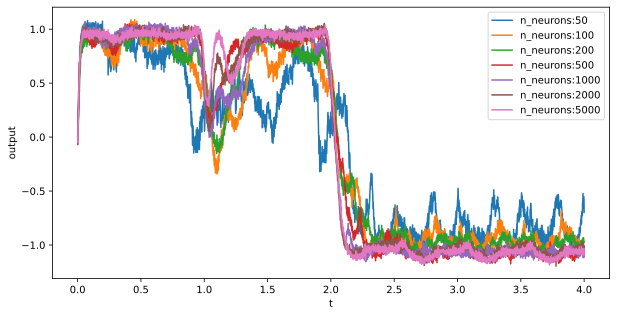

In [24]:
def rmse_classification(predicted):
    target = np.zeros((4000,1))
    target[:2000] = 1
    target[2000:] = -1
    
    return np.sqrt(np.mean(np.square(target.T[0] - predicted.T[0])))
    

n_neurons_array = [50, 100, 200, 500, 1000, 2000, 5000]
rmse_n_neurons = np.zeros(len(n_neurons_array))
plt.figure(figsize=(10,5))
plt.xlabel("t")
plt.ylabel("output")
for i,x in enumerate(n_neurons_array): 
    t, class_result = lmu_classification(x, 6);
    plt.plot(t, class_result, label="n_neurons:"+str(x))
    rmse_n_neurons[i] = rmse_classification(class_result)
plt.legend(); 

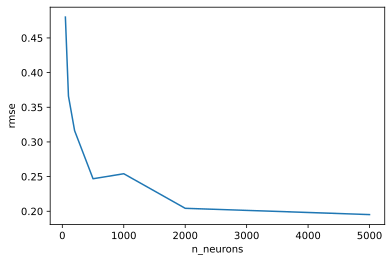

In [25]:
plt.figure()
plt.xlabel("n_neurons")
plt.ylabel("rmse")
plt.plot(n_neurons_array, rmse_n_neurons)

In [26]:
rmse_n_neurons

array([0.48008512, 0.3660648 , 0.31621406, 0.24686802, 0.25409771,
       0.20422129, 0.19515753])

The model performs better when the number of neurons increases for the LMU ensemble, because more information can be preserved when number of neuron increases. This is proved by the decreasing rmse graphed above. 

**e) Adjusting the q value. [2 marks]** Repeat part b) (returning to 1000 neurons) but adjust the value of `q`.  Try 1, 2, 4, 8, 16, 32, and 64.  How does the model behaviour change?  Why does this happen? In addition to looking at the actual results for each run, also plot the RMSE in the classification as you adjust the number of neurons.  

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

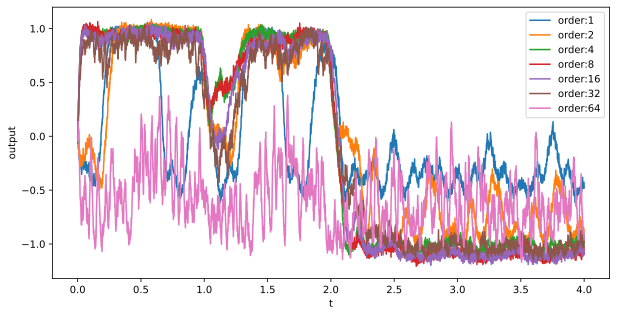

In [27]:
q_array = [1,2,4,8,16,32,64]
rmse_q_array = np.zeros(len(q_array))
plt.figure(figsize=(10,5))
plt.xlabel("t")
plt.ylabel("output")
for i,x in enumerate(q_array): 
    t, class_result = lmu_classification(1000, x);
    plt.plot(t, class_result, label="order:"+str(x))
    rmse_q_array[i] = rmse_classification(class_result)
plt.legend(); 

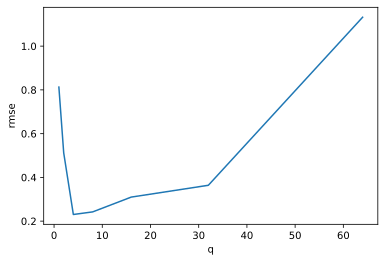

In [28]:
plt.figure()
plt.xlabel("q")
plt.ylabel("rmse")
plt.plot(q_array, rmse_q_array)

The model performs well when the order of polynomials increases to around 4-8, and performance decreases after order 8 as shown by increase in RMSE. This is because since increasing the order of the Legendre polynomials decreases the linearity, after a certain degree, the polynomials would not extract the neural population well. Higher-order polynomials are also not as well encoded by the neuron population as the lower-order ones, resulting in larger errors. 

# 3. Online Learning

Normally when build models with the Neural Engineering Framework, we compute the connection weights at the beginning and then leave them fixed while running the model.  But, we can also apply online learning rules to adjust the connection weights over time.  This has the effect of changing the function being computed.  One general learning rule is the PES rule, where you provide an extra input that indicates whether the output value should be increased or decreased.  This is generally called an error signal.

**a) Basic online learning. [2 marks]** Build a network that will learn the identity function.  You will need three `Ensembles`, one for the input, one for the output, and one for the error. Each one is 1-dimensional and uses 200 neurons.  For the input, use Nengo to randomly generate a 2Hz band-limited white noise signal as follows:

```python
stim = nengo.Node(nengo.processes.WhiteSignal(period=100, high=2, rms=0.3))
```

When making the learning connection, initialize it to compute the zero function and to use the PES learning rule as follows:
```python
def initialization(x):
    return 0
c = nengo.Connection(pre, post, function=initialization, learning_rule_type=nengo.PES(learning_rate=1e-4))
```

The error `Ensemble` should compute the difference between the output value and the desired output value.  For this initial question, we want the output value to be the same as the input value (i.e. we are learning the identity function).  Then connect the error `Ensemble` to the learning rule as follows:

```python
nengo.Connection(error, c.learning_rule)
```

(Note: for this question, leave the `synapse` values on the `Connections` at their default values)

Run the model for 10 seconds and plot the input value and the resulting output value (using a `Probe` with `synapse=0.01`).  The output should match the input fairly well after the first few seconds.

In [29]:
def learning(sim_time, learning_rate): 
    with nengo.Network() as net:
        # create the input signal
        inp = nengo.Node(nengo.processes.WhiteSignal(period=100, high=2, rms=0.3))

        # create neuron ensembles 
        pre = nengo.Ensemble(200, dimensions=1)
        post = nengo.Ensemble(200, dimensions=1)
        error = nengo.Ensemble(200, dimensions=1)

        nengo.Connection(inp, pre)

        def initialization(x):
            return 0
        conn = nengo.Connection(pre, post, function=initialization, learning_rule_type=nengo.PES(learning_rate=learning_rate))

        # Error = actual - target = post - pre
        nengo.Connection(post, error)
        nengo.Connection(pre, error, transform=-1)

        nengo.Connection(error, conn.learning_rule)


        inp_p = nengo.Probe(inp)
        pre_p = nengo.Probe(pre, synapse=0.01)
        post_p = nengo.Probe(post, synapse=0.01)
        error_p = nengo.Probe(error, synapse=0.01)

        with nengo.Simulator(net) as sim:
            sim.run(sim_time)

    return sim.trange(), sim.data[inp_p], sim.data[pre_p], sim.data[post_p]

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

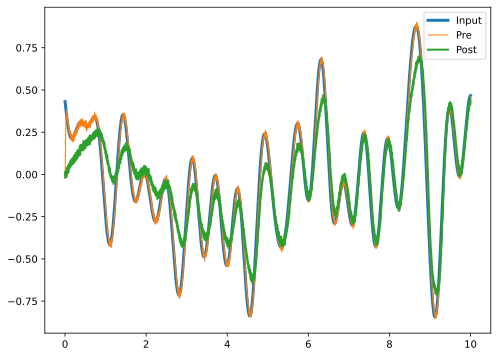

In [30]:
t, inp, pre, post = learning(10, 1e-4)

plt.figure(figsize=(8, 6))
plt.plot(t, inp, linewidth=3, label="Input")
plt.plot(t, pre, linewidth=1, label="Pre")
plt.plot(t, post, linewidth=2, label="Post")
plt.legend(loc="best")

**b) Error calculation. [1 mark]**  What would happen if you reversed the sign of the error calculation (i.e. if you did `target - output` rather than `output - target`?  Why does that happen?

If the sign is reversed, the error signal computed for PES learning would have a reversed direction (reversed sign). This causes the updated decoder to have an opposite direction. If a neuron is active while there is some positive error, its influence on decoding is actually increased. This means that learning would not occur properly and neuron will fail to learn the function. 

**c) Computing metrics. [1 mark]**  Break your data up into 2-second chunks and compute the Root-Mean-Squared-Error between the target value (the stimulus itself) and the output from the model for each chunk.  Since the simulation is 10 seconds long, you should have 5 RMSE measures (one for the first 2 seconds, one for the second 2 seconds, one for the third 2 seconds, and so on).  Repeat the simulation 10 times and plot the average for each of these values.  The result should show that the model gets better over time, but does not reach 0 error.  

In [31]:
def rmse_chunks(target, predicted):    
    rmse = np.zeros(int(len(target)/2000))
    
    for i in range(0,len(rmse)): 
        target_i = target[i*2000:(i+1)*2000]
        predicted_i = predicted[i*2000:(i+1)*2000]
        rmse[i] = np.sqrt(np.mean(np.square(target_i.T[0] - predicted_i.T[0])))
    
    return rmse

In [32]:
rmse_all = []

for i in range(0, 10): 
    t, inp, pre, post = learning(10, 1e-4)
    rmse_10 = rmse_chunks(inp, post)
    rmse_all.append(rmse_10)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

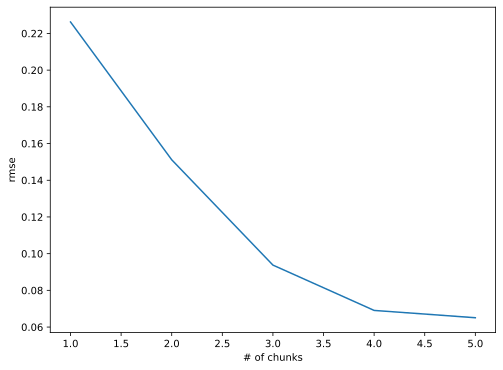

In [33]:
def find_averaged_rmse(rmse_all): 
    rms = rmse_all.T
    rms_avg = np.zeros(rms.shape[0]) 
    for i in range(0, rms.shape[0]): 
        rms_avg[i] = np.mean(rms[i]) 
        
    return rms_avg

rmse_avg = find_averaged_rmse(np.asarray(rmse_all))
num_chunks = np.arange(1, len(rmse_avg)+1)

plt.figure(figsize=(8, 6))
plt.xlabel("# of chunks")
plt.ylabel("rmse")
plt.plot(num_chunks, rmse_avg)

**d) Increasing learning time. [2 marks]**  Repeat part (c), but run the model for 100 seconds instead of 10 seconds.  How do the results change?

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

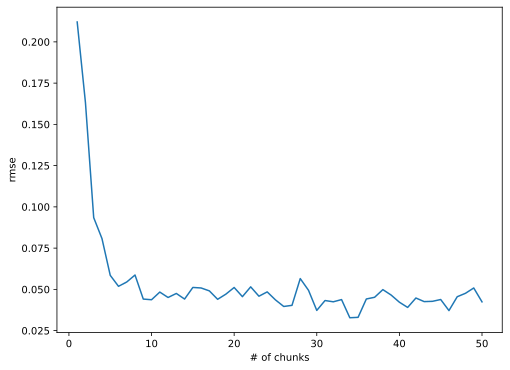

In [34]:
rmse_all = []

for i in range(0, 10): 
    t, inp, pre, post = learning(100, 1e-4)
    rmse_100 = rmse_chunks(inp, post)
    rmse_all.append(rmse_100)

rmse_avg = find_averaged_rmse(np.asarray(rmse_all))
num_chunks = np.arange(1, len(rmse_avg)+1)

plt.figure(figsize=(8, 6))
plt.xlabel("# of chunks")
plt.ylabel("rmse")
plt.plot(num_chunks, rmse_avg)

The starting rmse in the first 10s (first 5 chunks) is relatively the same as when the simulation is ran for 10s. After 20s (10 chunks), the change in rmse is not significant and it is kept at a stable number of around 0.05. This means that the learning after 20s has relatively stable performance. 

**e) Learning rates. [2 marks]**  Repeat part (d), but decrease the learning rate to `1e-5`.  How do the results change?  How do they compare to part (c)?

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

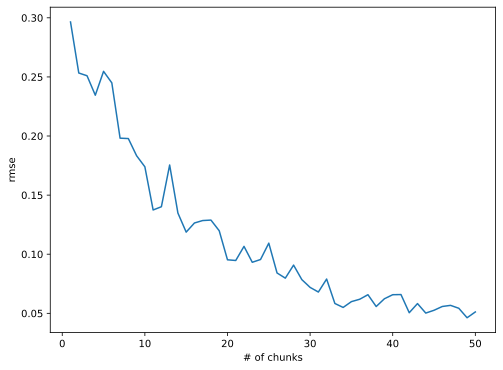

In [35]:
rmse_all = []

for i in range(0, 10): 
    t, inp, pre, post = learning(100, 1e-5)
    rmse_100 = rmse_chunks(inp, post)
    rmse_all.append(rmse_100)

rmse_avg = find_averaged_rmse(np.asarray(rmse_all))
num_chunks = np.arange(1, len(rmse_avg)+1)

plt.figure(figsize=(8, 6))
plt.xlabel("# of chunks")
plt.ylabel("rmse")
plt.plot(num_chunks, rmse_avg)

When the learning rate decreases, it can be observed that it takes longer time to reach a stable, consistent rmse level that indicates consistent performance in learning. In comparison to part d) where it took around 10s to reach a steady rmse, it takes around 70s when learning rate is decreased in part e). In comparison to c) when learning rate is larger and simulation is ran for a shorter amount of time, the rmse when learning rate is smaller is also larger at the beginning. 

**f) Improving performance. [1 mark]**  If you wanted to make the learned result even more accurate, how would you do this?  What would you change about the model and learning process?

One thing to try is to modify the pre-synapse lowpass filtered applied to activities of pre-synaptic population before computing each update decoders. The default PES pre-synapse lowpass filter has a time-constant of $tau = 5ms$. Generally, longer time constants smooth over spiking activity to produce more constant updates, while shorter time constants adapt more quickly to rapidly changing inputs. In this case, we might decrease the time constant to increase the change in decoder values each time an update occurs. 

**g) Learning other functions. [1 mark]** Repeat part (a), but have the system learn a function where the input is a scalar $x$, but the output is the vector $[x^2, -x]$.  This will involve changing the dimensionality of some of the `Ensembles` and adding a `function=` to be computed on the `Connection` from the `stim` to the `error`.

In [36]:
def learning_function(sim_time, learning_rate): 
    with nengo.Network() as net:
        # create the input signal
        inp = nengo.Node(nengo.processes.WhiteSignal(period=100, high=2, rms=0.3))

        # create neuron ensembles 
        pre = nengo.Ensemble(200, dimensions=1)
        post = nengo.Ensemble(200, dimensions=2)
        error = nengo.Ensemble(200, dimensions=2)

        nengo.Connection(inp, pre)

        def initialization(x): 
            return [0,0]
        
        conn = nengo.Connection(pre, post, function=initialization, learning_rule_type=nengo.PES(learning_rate=learning_rate))
        
        def function_post(x):
            return [x**2, -x]
        nengo.Connection(error, conn.learning_rule)
        
        # Error = actual - target = post - pre
        nengo.Connection(post, error)
        nengo.Connection(pre, error, function=function_post, transform=[-1, -1])


        inp_p = nengo.Probe(inp)
        pre_p = nengo.Probe(pre, synapse=0.01)
        post_p = nengo.Probe(post, synapse=0.01)
        error_p = nengo.Probe(error, synapse=0.01)

        with nengo.Simulator(net) as sim:
            sim.run(sim_time)

    return sim.trange(), sim.data[inp_p], sim.data[pre_p], sim.data[post_p]

In [37]:
t, inp, pre, post = learning_function(10, 1e-4)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

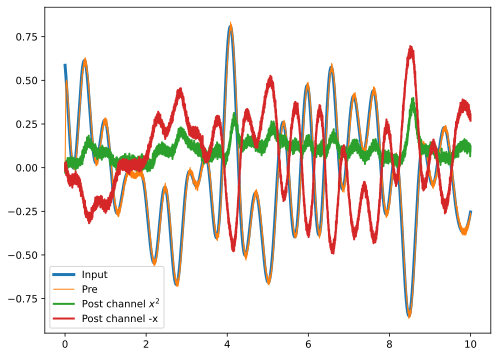

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(t, inp, linewidth=3, label="Input")
plt.plot(t, pre, linewidth=1, label="Pre")
plt.plot(t, post[:,0], linewidth=2, label="Post channel $x^2$")
plt.plot(t, post[:,1], linewidth=2, label="Post channel -x")
plt.legend(loc="best")